# AIOps Demonstration Notebook


In [454]:
# Step 1: Setup Environment
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [455]:
# Step 2: Load and Explore Data
import pandas as pd
import numpy as np
import logging

# Load your datasets
server_metrics = pd.read_csv("server_metrics.csv")
business_metrics = pd.read_csv("business_metrics.csv")

# Display basic information and statistics
print(server_metrics.info())
print(server_metrics.describe())

print(business_metrics.info())
print(business_metrics.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Timestamp                      3000 non-null   object 
 1   CPU Utilization (%)            3000 non-null   float64
 2   Memory Utilization (%)         3000 non-null   float64
 3   Network I/O Throughput (Mbps)  3000 non-null   float64
 4   Disk I/O Throughput (MB/s)     3000 non-null   float64
 5   Server Configuration           3000 non-null   object 
dtypes: float64(4), object(2)
memory usage: 140.8+ KB
None
       CPU Utilization (%)  Memory Utilization (%)  \
count          3000.000000             3000.000000   
mean             27.438206               41.001839   
std              33.387453               15.813472   
min               0.001396               10.063554   
25%               2.216836               28.265768   
50%               4.240580     

In [456]:
# Step 3: Data Preprocessing

# Fill missing values with the mean for numeric columns, preserving the Timestamp column
server_metrics_numeric = server_metrics.select_dtypes(include="number").fillna(
    server_metrics.select_dtypes(include="number").mean()
)
server_metrics_non_numeric = server_metrics.select_dtypes(exclude="number")
server_metrics = pd.concat([server_metrics_non_numeric, server_metrics_numeric], axis=1)

business_metrics_numeric = business_metrics.select_dtypes(include="number").fillna(
    business_metrics.select_dtypes(include="number").mean()
)
business_metrics_non_numeric = business_metrics.select_dtypes(exclude="number")
business_metrics = pd.concat(
    [business_metrics_non_numeric, business_metrics_numeric], axis=1
)

# Print columns to ensure 'Timestamp' is preserved
print("Server Metrics Columns After Preprocessing:")
print(server_metrics.columns)

print("Business Metrics Columns After Preprocessing:")
print(business_metrics.columns)

print("Data Preprocessing Completed.")

Server Metrics Columns After Preprocessing:
Index(['Timestamp', 'Server Configuration', 'CPU Utilization (%)',
       'Memory Utilization (%)', 'Network I/O Throughput (Mbps)',
       'Disk I/O Throughput (MB/s)'],
      dtype='object')
Business Metrics Columns After Preprocessing:
Index(['Timestamp', 'Server Configuration', 'Response Time (ms)',
       'Customer Satisfaction (CSAT)', 'Operational Costs ($)',
       'Service Uptime (%)'],
      dtype='object')
Data Preprocessing Completed.


Silhouette Score: 0.40290237786432576


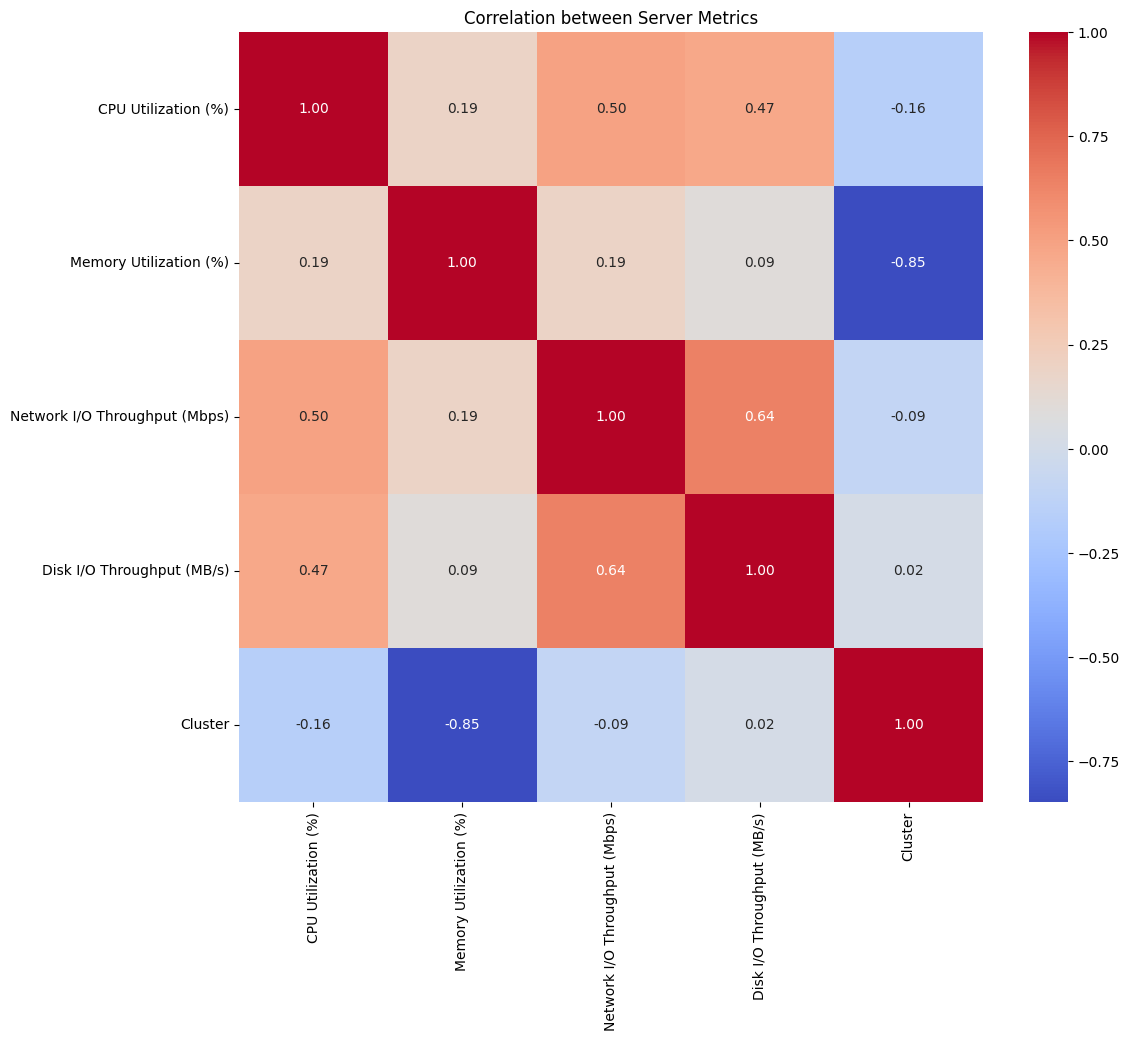

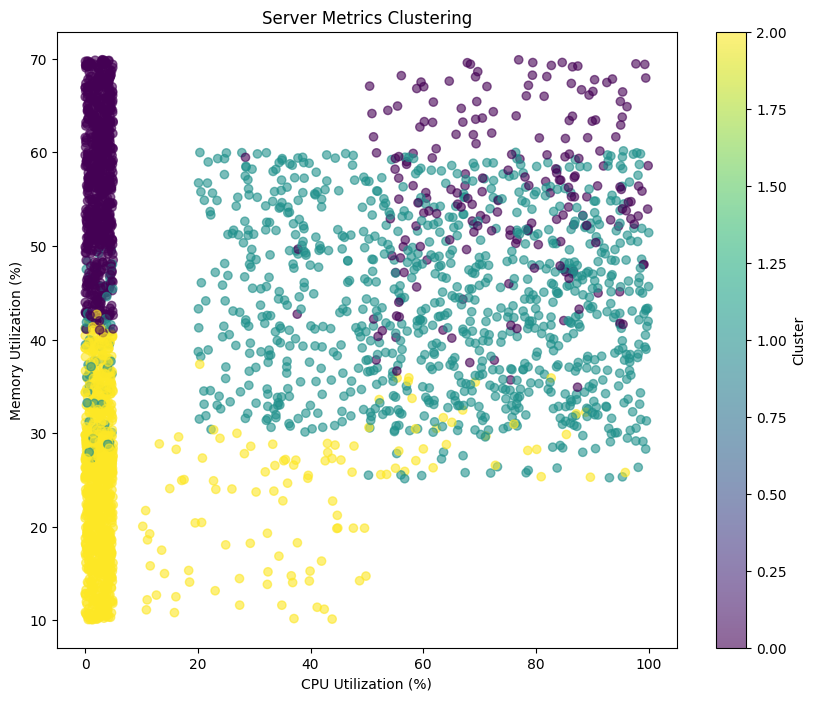

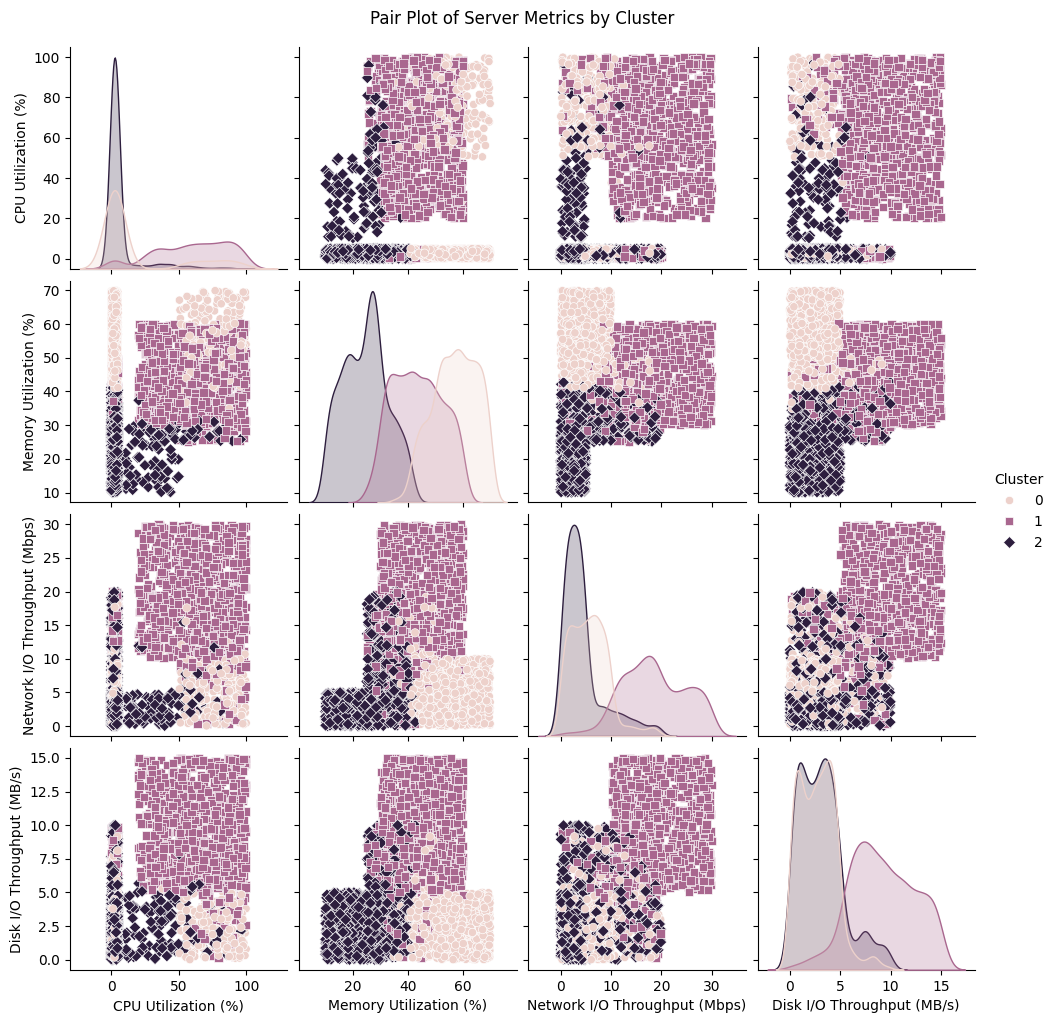

In [457]:
# Step 4: Data Analysis and Insights
# Clustering Analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalize/Scale Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
server_metrics_scaled = scaler.fit_transform(
    server_metrics.select_dtypes(include="number")
)

# Example: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
server_clusters = kmeans.fit_predict(server_metrics_scaled)

# Add cluster labels to the original dataframe
server_metrics["Cluster"] = server_clusters

# Calculate silhouette score for evaluating the clustering
silhouette_avg = silhouette_score(server_metrics_scaled, server_clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics
numeric_server_metrics = server_metrics.select_dtypes(include="number")
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_server_metrics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics")
plt.show()

# Scatter plot of clusters for CPU and Memory Utilization
plt.figure(figsize=(10, 8))
plt.scatter(
    server_metrics["CPU Utilization (%)"],
    server_metrics["Memory Utilization (%)"],
    c=server_metrics["Cluster"],
    cmap="viridis",
    alpha=0.6,
)
plt.colorbar(label="Cluster")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Memory Utilization (%)")
plt.title("Server Metrics Clustering")
plt.show()

# Pair plot for visualizing the clusters across multiple features
sns.pairplot(server_metrics, hue="Cluster", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pair Plot of Server Metrics by Cluster", y=1.02)
plt.show()

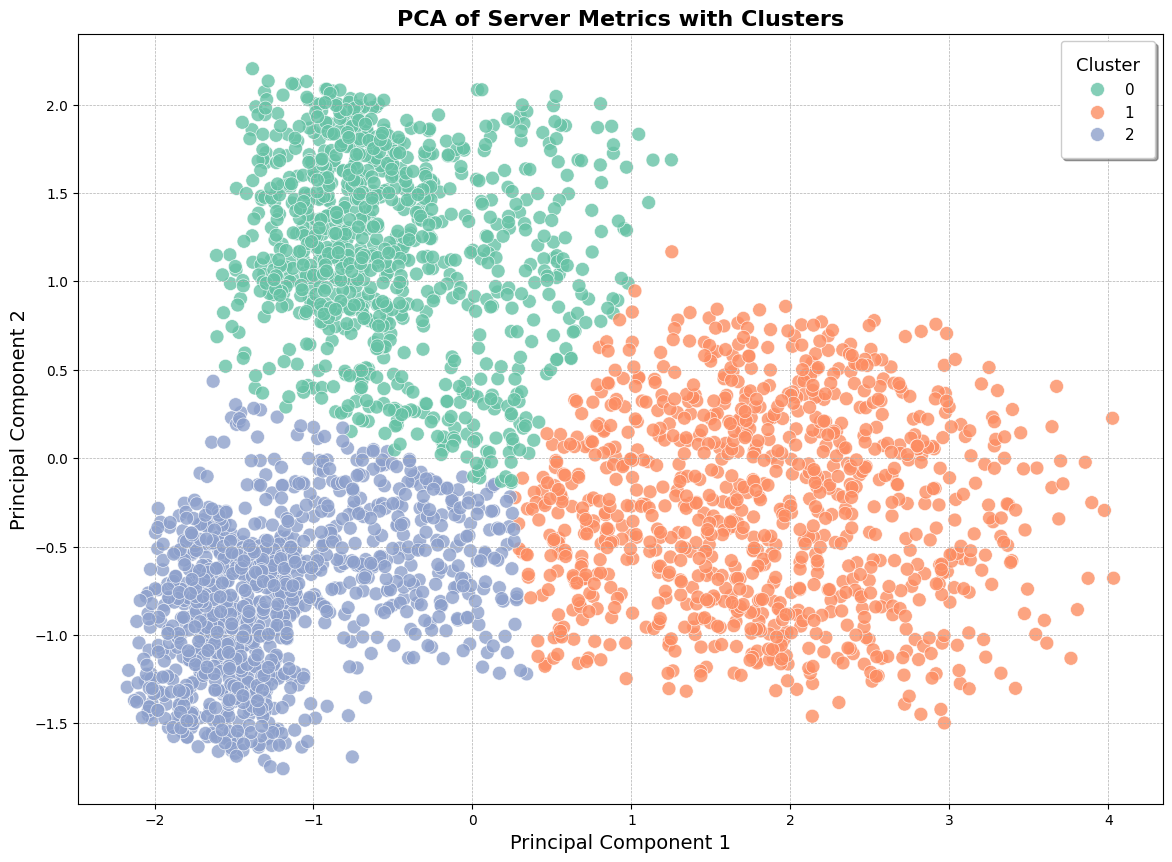

Shape of scaled data: (3000, 4)
Number of features: 4
PCA Loadings:
                                    PC1       PC2
CPU Utilization (%)            0.527929 -0.008755
Memory Utilization (%)         0.230183  0.957444
Network I/O Throughput (Mbps)  0.589364 -0.109567
Disk I/O Throughput (MB/s)     0.566530 -0.266870


In [458]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def get_pca_loadings(pca, features):
    """
    Get PCA loadings for the specified features.

    Args:
    - pca (PCA): Fitted PCA model.
    - features (list): List of features.

    Returns:
    - pd.DataFrame: DataFrame containing PCA loadings.
    """
    try:
        if pca.components_.shape[1] != len(features):
            raise ValueError("Mismatch between PCA components and feature length.")
        loadings = pd.DataFrame(
            pca.components_.T, columns=["PC1", "PC2"], index=features
        )
        return loadings
    except Exception as e:
        logging.error(f"An error occurred while retrieving PCA loadings: {e}")
        return pd.DataFrame()


# Ensure the correct columns are selected for scaling and PCA
numeric_server_metrics = server_metrics.select_dtypes(include="number").drop(
    columns=["Cluster"]
)

# Normalize/Scale Data
scaler = StandardScaler()
server_metrics_scaled = scaler.fit_transform(numeric_server_metrics)


# PCA Analysis and Visualization
def apply_pca(scaled_data, clusters):
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(scaled_data)
        pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
        pca_df["Cluster"] = clusters

        plt.figure(figsize=(14, 10))
        sns.scatterplot(
            x="PC1",
            y="PC2",
            hue="Cluster",
            palette="Set2",
            data=pca_df,
            s=100,
            alpha=0.8,
            edgecolor="w",
            linewidth=0.5,
        )
        plt.title("PCA of Server Metrics with Clusters", fontsize=16, weight="bold")
        plt.xlabel("Principal Component 1", fontsize=14)
        plt.ylabel("Principal Component 2", fontsize=14)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend(
            title="Cluster",
            title_fontsize="13",
            fontsize="11",
            loc="upper right",
            frameon=True,
            shadow=True,
            borderpad=1,
        )
        plt.show()

        return pca_df, pca
    except Exception as e:
        logging.error(f"An error occurred during PCA: {e}")
        return None, None


# Apply PCA and visualize the clusters
pca_df, pca = apply_pca(server_metrics_scaled, server_clusters)

# Check the shape of the scaled data and the original feature columns
print(f"Shape of scaled data: {server_metrics_scaled.shape}")
print(f"Number of features: {len(numeric_server_metrics.columns)}")

# Get PCA loadings for feature interpretation
features = numeric_server_metrics.columns.tolist()
pca_loadings = get_pca_loadings(pca, features)
print("PCA Loadings:")
print(pca_loadings)

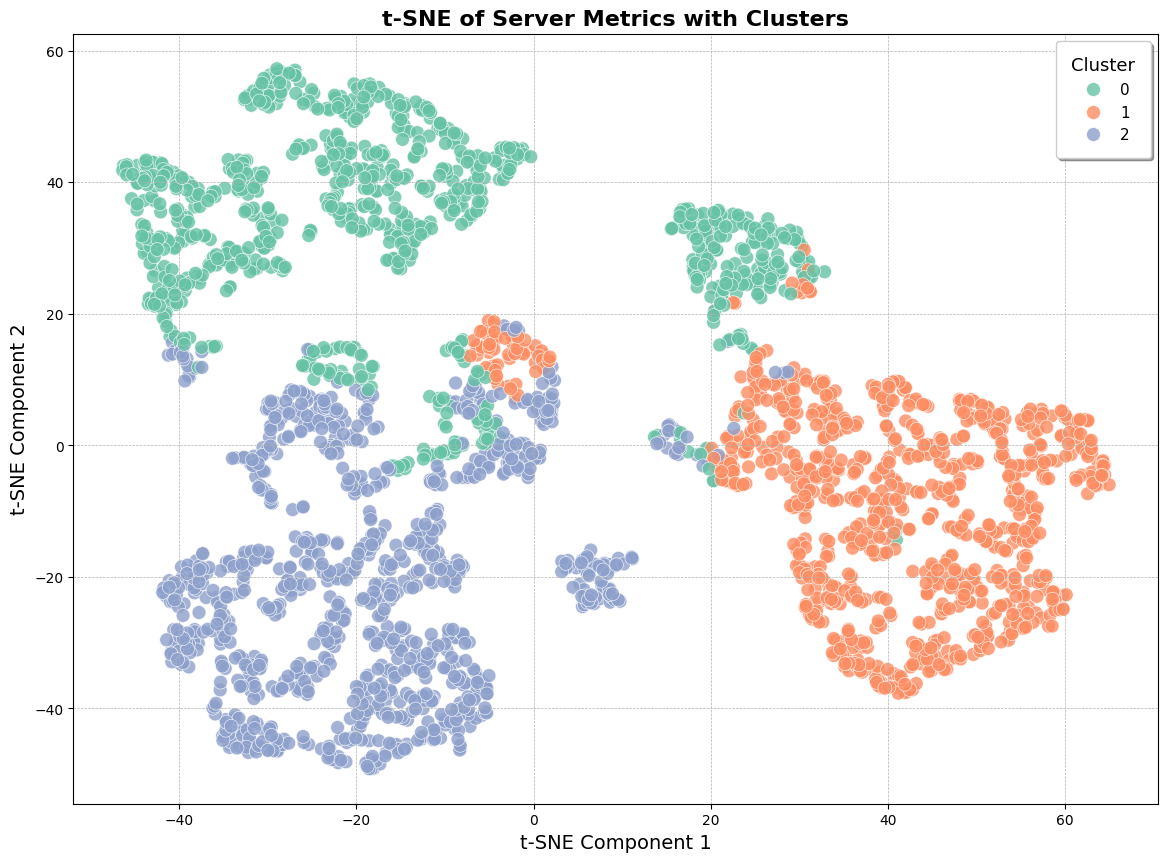

In [459]:
# Step 6: t-SNE Analysis and Visualization


def apply_tsne(scaled_data, clusters):
    """
    Apply t-SNE to the scaled data and plot the results.

    Args:
    - scaled_data (np.array): Scaled data.
    - clusters (np.array): Cluster labels.

    Returns:
    - pd.DataFrame: DataFrame containing t-SNE results and cluster labels.
    """
    try:
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(scaled_data)
        tsne_df = pd.DataFrame(data=X_tsne, columns=["TSNE1", "TSNE2"])
        tsne_df["Cluster"] = clusters

        plt.figure(figsize=(14, 10))
        sns.scatterplot(
            x="TSNE1",
            y="TSNE2",
            hue="Cluster",
            palette="Set2",
            data=tsne_df,
            s=100,
            alpha=0.8,
            edgecolor="w",
            linewidth=0.5,
        )
        plt.title("t-SNE of Server Metrics with Clusters", fontsize=16, weight="bold")
        plt.xlabel("t-SNE Component 1", fontsize=14)
        plt.ylabel("t-SNE Component 2", fontsize=14)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.legend(
            title="Cluster",
            title_fontsize="13",
            fontsize="11",
            loc="upper right",
            frameon=True,
            shadow=True,
            borderpad=1,
        )
        plt.show()

        return tsne_df
    except Exception as e:
        logging.error(f"An error occurred during t-SNE: {e}")
        return None


# Apply t-SNE and visualize the clusters
tsne_df = apply_tsne(server_metrics_scaled, server_clusters)

Calinski-Harabasz Index: 2247.517844967138
Davies-Bouldin Index: 0.9558127952031694
Cluster Counts:
Cluster
0     955
1     976
2    1069
Name: count, dtype: int64


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/3052406758.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


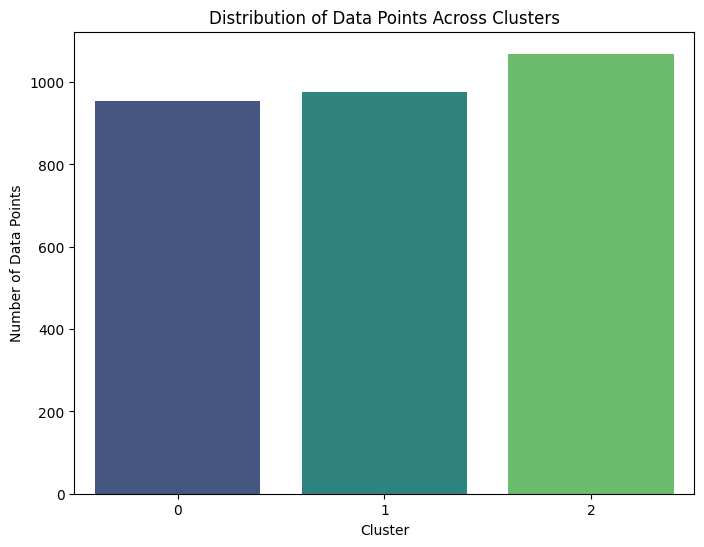

In [460]:
# Step 7: Evaluate Clustering Model Performance

from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(server_metrics_scaled, server_clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(server_metrics_scaled, server_clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")

# Check cluster distribution
cluster_counts = server_metrics["Cluster"].value_counts().sort_index()
print("Cluster Counts:")
print(cluster_counts)

# Visualize cluster distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.title("Distribution of Data Points Across Clusters")
plt.show()

--- KMeans ---
Silhouette Score: 0.40290237786432576
Calinski-Harabasz Index: 2247.517844967138
Davies-Bouldin Index: 0.9558127952031694
Cluster Counts:
0     955
1     976
2    1069
Name: count, dtype: int64


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


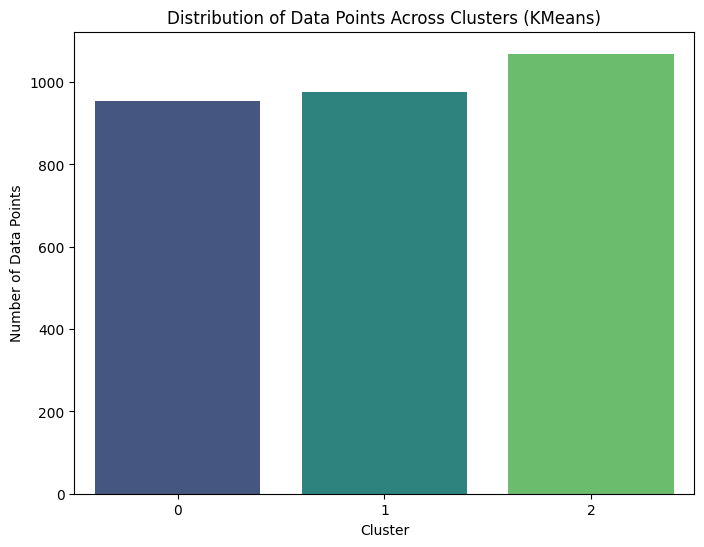

--- Agglomerative Clustering ---
Silhouette Score: 0.363782184903816
Calinski-Harabasz Index: 1841.7452174103212
Davies-Bouldin Index: 0.9283390918664819
Cluster Counts:
0    1144
1    1243
2     613
Name: count, dtype: int64


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


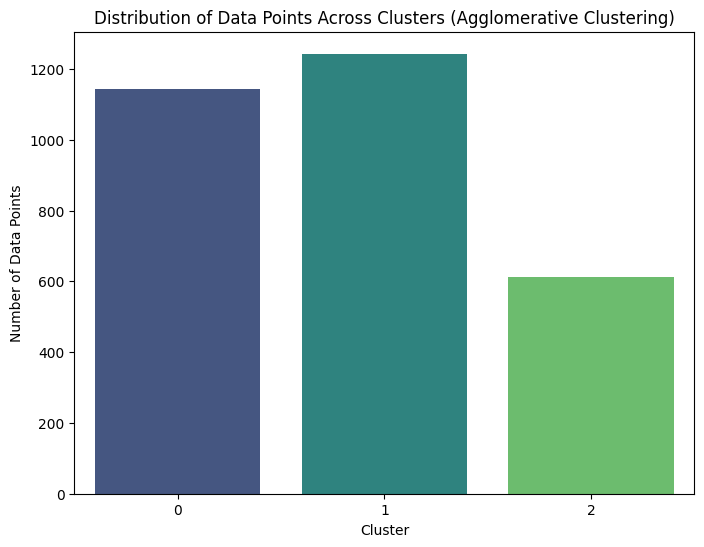

--- DBSCAN ---
Silhouette Score: -0.1530966079343188
Calinski-Harabasz Index: 7.688469732554705
Davies-Bouldin Index: 1.093857505819631
Cluster Counts:
0    2913
1       7
2       7
3       5
4       5
Name: count, dtype: int64


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


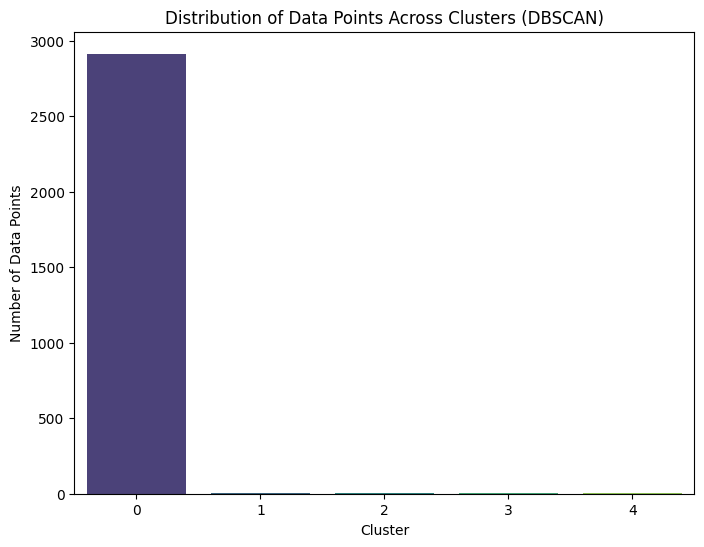

Performance Metrics Summary:
                  Algorithm  Silhouette Score  Calinski-Harabasz Index  \
0                    KMeans          0.402902              2247.517845   
1  Agglomerative Clustering          0.363782              1841.745217   
2                    DBSCAN         -0.153097                 7.688470   

   Davies-Bouldin Index  
0              0.955813  
1              0.928339  
2              1.093858  


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Algorithm", y="Silhouette Score", data=performance_df, palette="viridis")
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1790568531.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


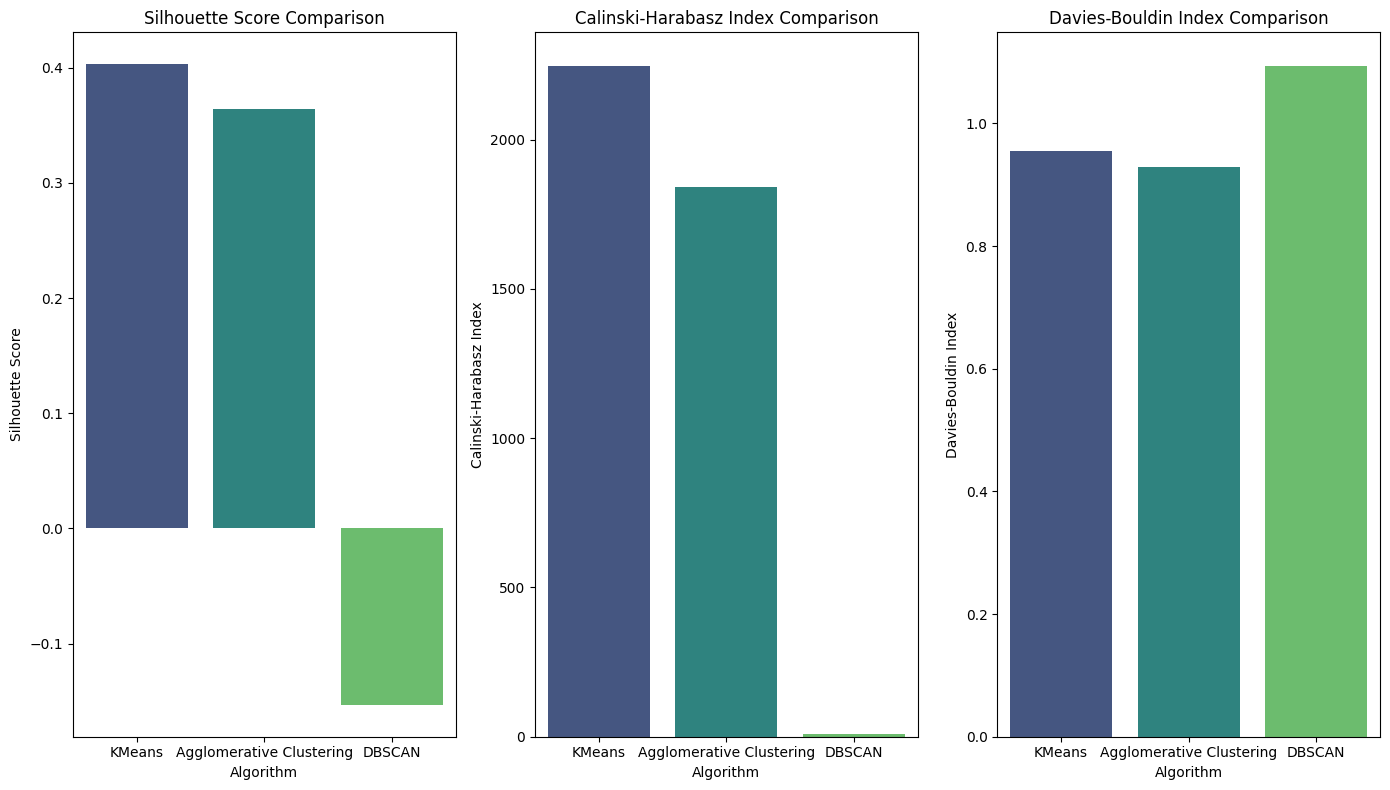

The best clustering algorithm based on Silhouette Score is: KMeans
PCA Visualization:
PCA of Server Metrics with KMeans Clusters


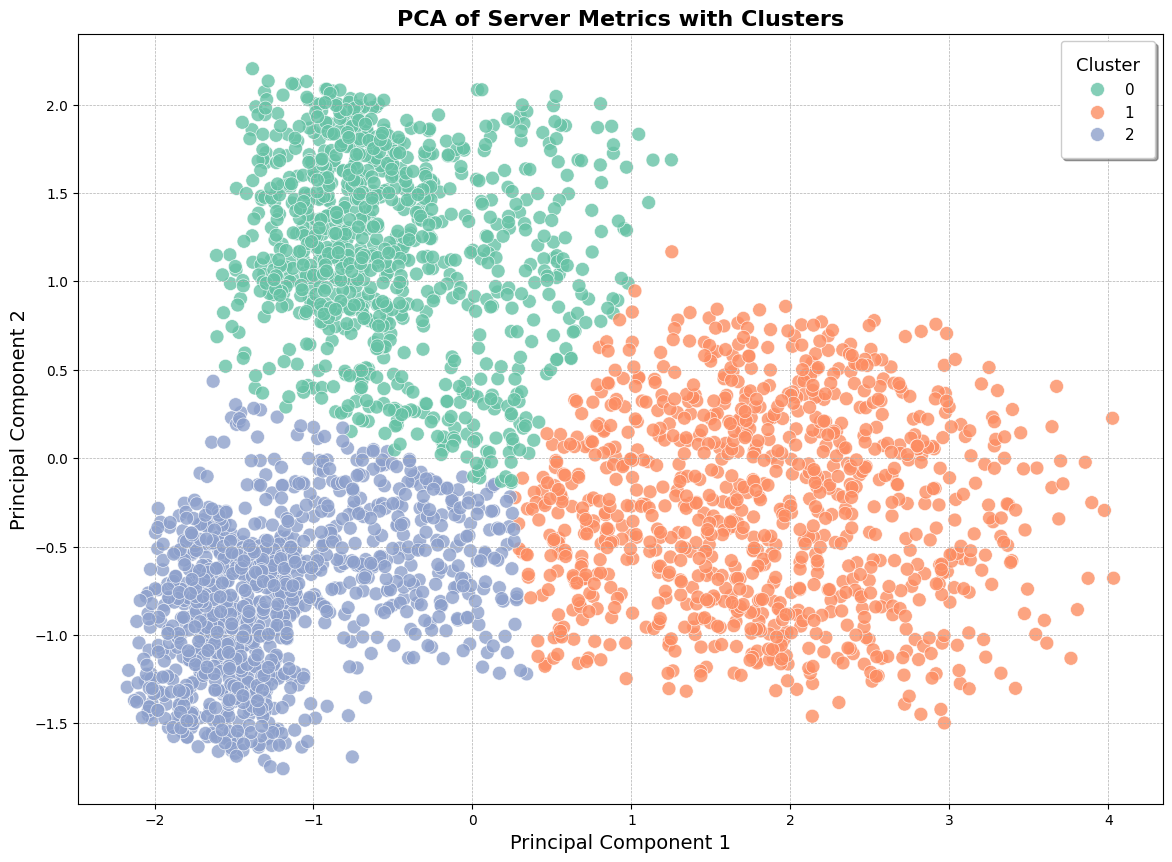

PCA of Server Metrics with Agglomerative Clustering Clusters


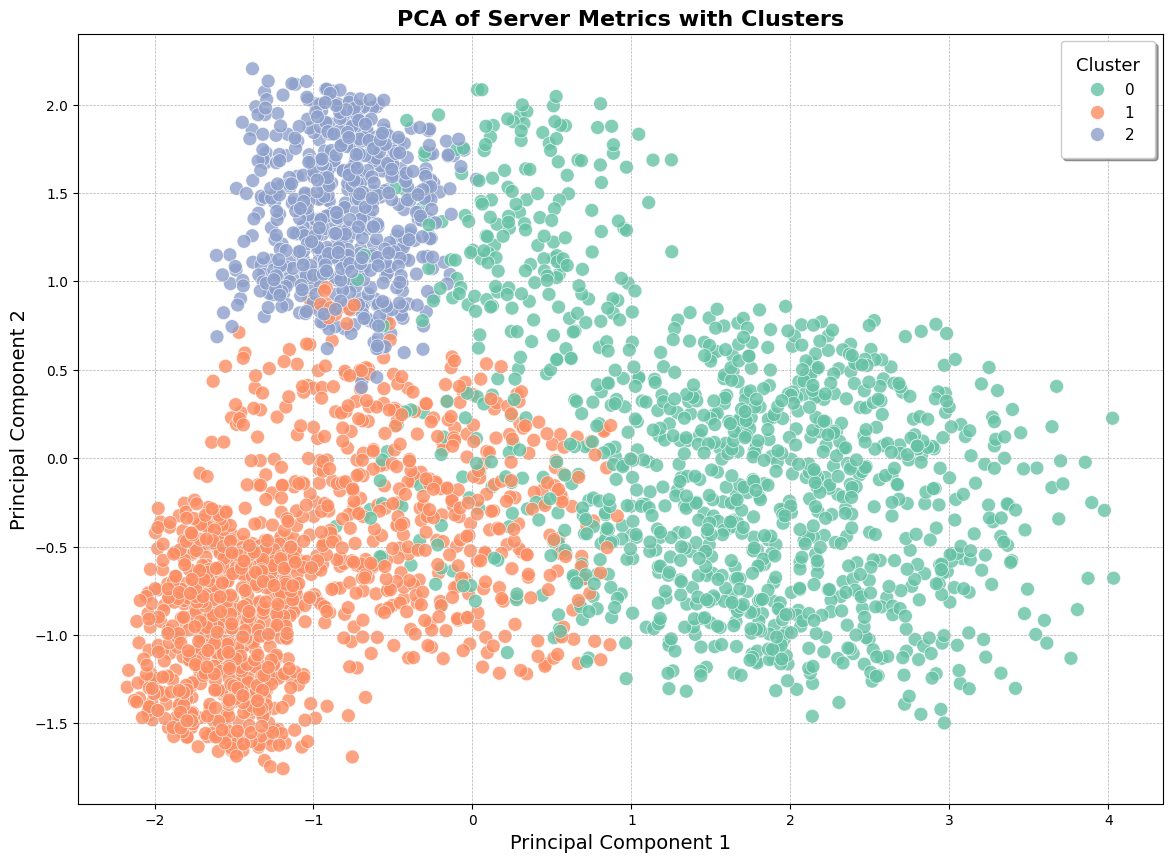

PCA of Server Metrics with DBSCAN Clusters


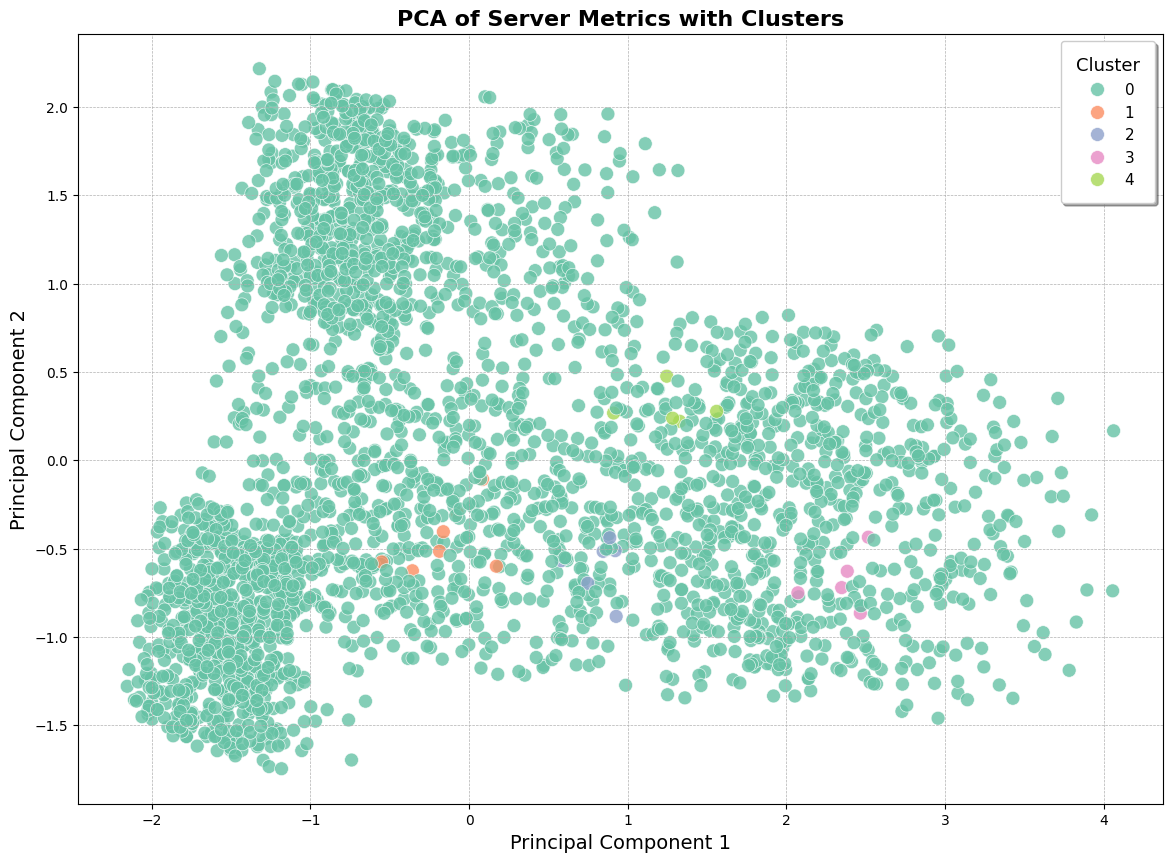

<Figure size 640x480 with 0 Axes>

t-SNE Visualization:
t-SNE of Server Metrics with KMeans Clusters


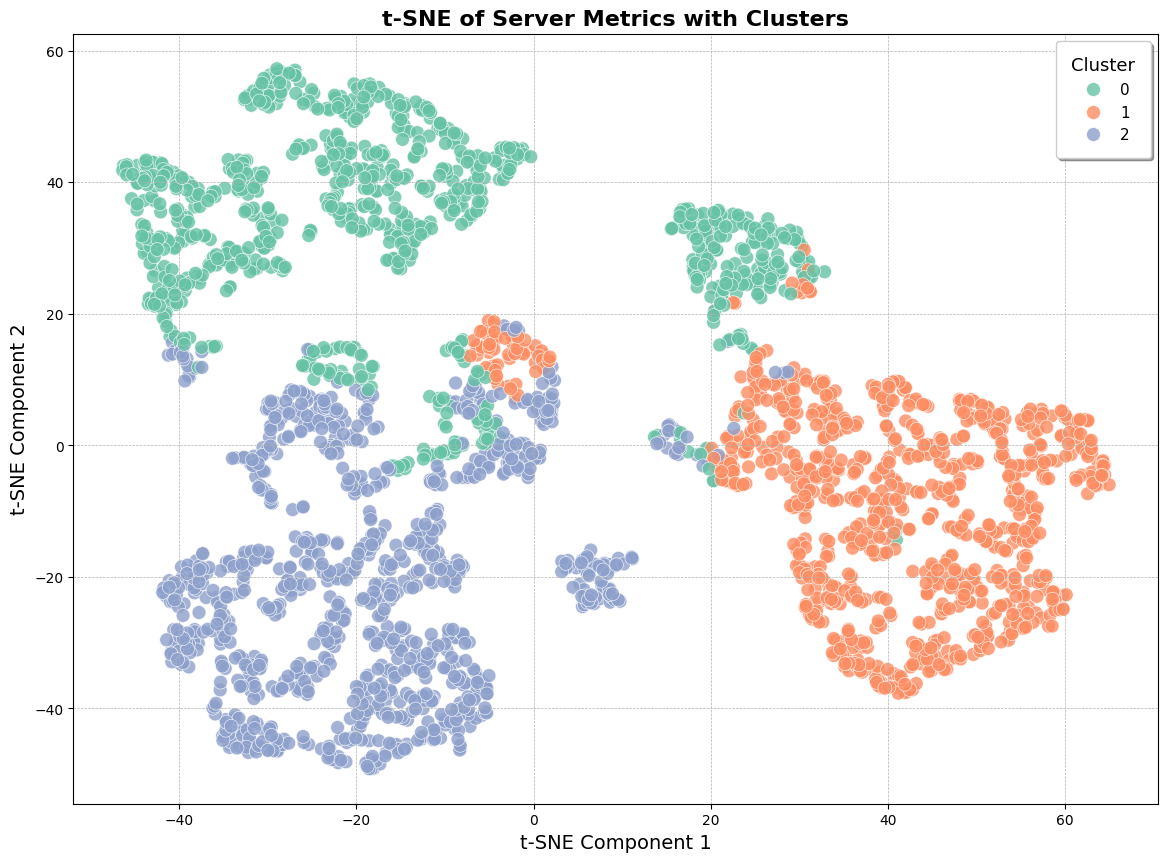

t-SNE of Server Metrics with Agglomerative Clustering Clusters


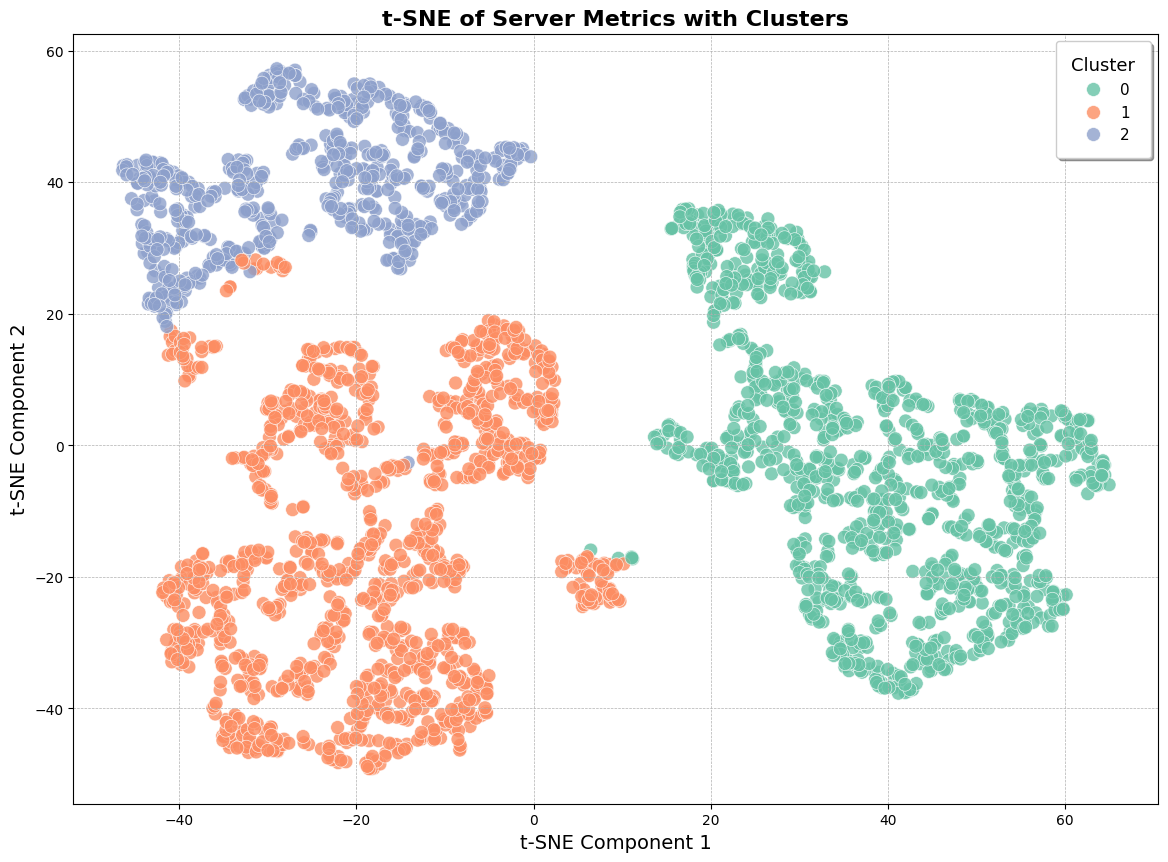

t-SNE of Server Metrics with DBSCAN Clusters


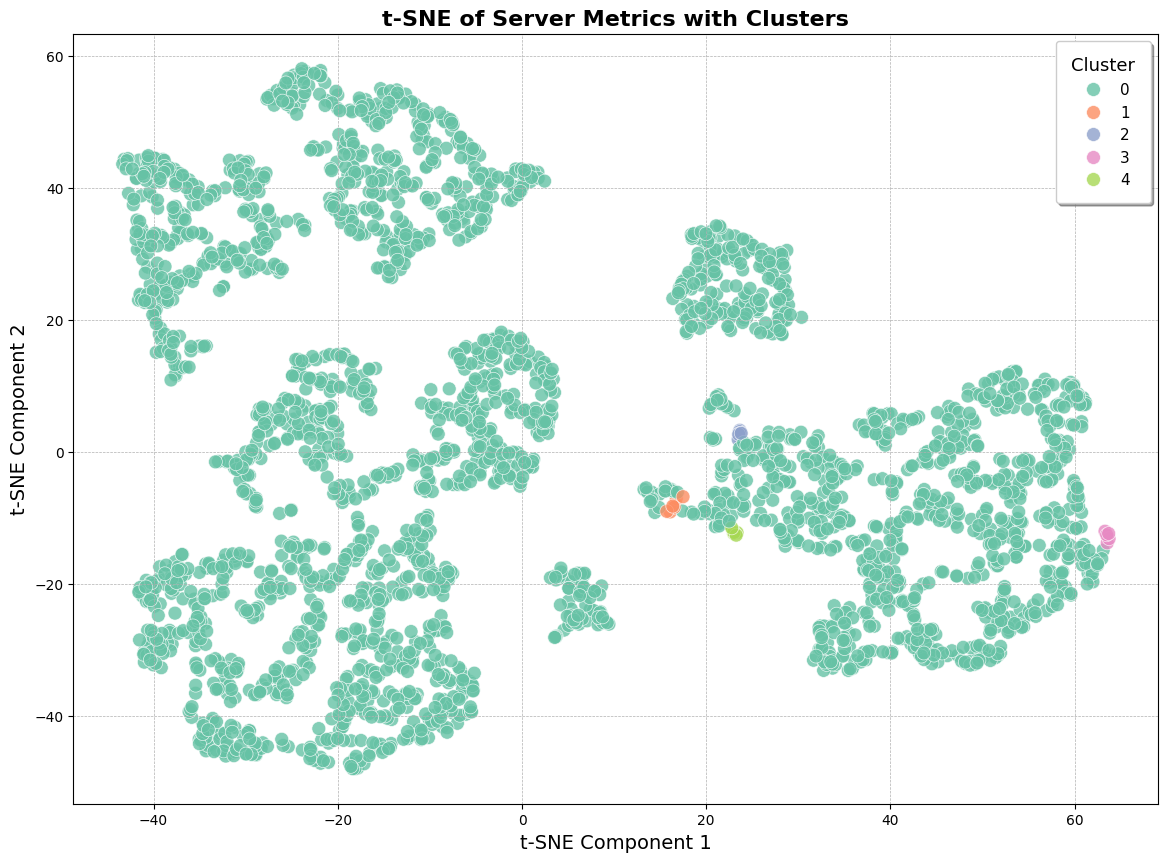

<Figure size 640x480 with 0 Axes>

In [461]:
# Step 8: Compare Clustering Algorithms

from sklearn.cluster import AgglomerativeClustering, DBSCAN


# Function to evaluate clustering performance
def evaluate_clustering(scaled_data, clusters, algorithm_name):
    silhouette_avg = silhouette_score(scaled_data, clusters)
    calinski_harabasz = calinski_harabasz_score(scaled_data, clusters)
    davies_bouldin = davies_bouldin_score(scaled_data, clusters)
    cluster_counts = pd.Series(clusters).value_counts().sort_index()

    print(f"--- {algorithm_name} ---")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print("Cluster Counts:")
    print(cluster_counts)

    # Visualize cluster distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Data Points")
    plt.title(f"Distribution of Data Points Across Clusters ({algorithm_name})")
    plt.show()

    return silhouette_avg, calinski_harabasz, davies_bouldin


# Dictionary to store performance metrics for each algorithm
performance_metrics = {
    "Algorithm": [],
    "Silhouette Score": [],
    "Calinski-Harabasz Index": [],
    "Davies-Bouldin Index": [],
}

# Evaluate KMeans
kmeans_silhouette, kmeans_calinski, kmeans_davies = evaluate_clustering(
    server_metrics_scaled, kmeans_clusters, "KMeans"
)
performance_metrics["Algorithm"].append("KMeans")
performance_metrics["Silhouette Score"].append(kmeans_silhouette)
performance_metrics["Calinski-Harabasz Index"].append(kmeans_calinski)
performance_metrics["Davies-Bouldin Index"].append(kmeans_davies)

# Evaluate Agglomerative Clustering
agg_silhouette, agg_calinski, agg_davies = evaluate_clustering(
    server_metrics_scaled, agg_clusters, "Agglomerative Clustering"
)
performance_metrics["Algorithm"].append("Agglomerative Clustering")
performance_metrics["Silhouette Score"].append(agg_silhouette)
performance_metrics["Calinski-Harabasz Index"].append(agg_calinski)
performance_metrics["Davies-Bouldin Index"].append(agg_davies)

# Evaluate DBSCAN
dbscan_silhouette, dbscan_calinski, dbscan_davies = evaluate_clustering(
    server_metrics_scaled_filtered, dbscan_clusters_filtered, "DBSCAN"
)
performance_metrics["Algorithm"].append("DBSCAN")
performance_metrics["Silhouette Score"].append(dbscan_silhouette)
performance_metrics["Calinski-Harabasz Index"].append(dbscan_calinski)
performance_metrics["Davies-Bouldin Index"].append(dbscan_davies)

# Create DataFrame from performance metrics
performance_df = pd.DataFrame(performance_metrics)
print("Performance Metrics Summary:")
print(performance_df)

# Plot the performance metrics
plt.figure(figsize=(14, 8))

# Silhouette Score
plt.subplot(1, 3, 1)
sns.barplot(x="Algorithm", y="Silhouette Score", data=performance_df, palette="viridis")
plt.title("Silhouette Score Comparison")

# Calinski-Harabasz Index
plt.subplot(1, 3, 2)
sns.barplot(
    x="Algorithm", y="Calinski-Harabasz Index", data=performance_df, palette="viridis"
)
plt.title("Calinski-Harabasz Index Comparison")

# Davies-Bouldin Index
plt.subplot(1, 3, 3)
sns.barplot(
    x="Algorithm", y="Davies-Bouldin Index", data=performance_df, palette="viridis"
)
plt.title("Davies-Bouldin Index Comparison")

plt.tight_layout()
plt.show()

# Identify the best algorithm based on Silhouette Score
best_algorithm = performance_df.loc[performance_df["Silhouette Score"].idxmax()][
    "Algorithm"
]
print(f"The best clustering algorithm based on Silhouette Score is: {best_algorithm}")

# Visual Inspection with PCA for all algorithms
print("PCA Visualization:")

print("PCA of Server Metrics with KMeans Clusters")
apply_pca(server_metrics_scaled, kmeans_clusters)

print("PCA of Server Metrics with Agglomerative Clustering Clusters")
apply_pca(server_metrics_scaled, agg_clusters)

print("PCA of Server Metrics with DBSCAN Clusters")
apply_pca(server_metrics_scaled_filtered, dbscan_clusters_filtered)


plt.tight_layout()
plt.show()

# Visual Inspection with t-SNE for all algorithms
print("t-SNE Visualization:")

print("t-SNE of Server Metrics with KMeans Clusters")
apply_tsne(server_metrics_scaled, kmeans_clusters)

print("t-SNE of Server Metrics with Agglomerative Clustering Clusters")
apply_tsne(server_metrics_scaled, agg_clusters)

print("t-SNE of Server Metrics with DBSCAN Clusters")
apply_tsne(server_metrics_scaled_filtered, dbscan_clusters_filtered)

plt.tight_layout()
plt.show()

In [462]:
# Insights Based on PCA, t-SNE, and Clustering

# Display silhouette score
print(f"Silhouette Score: {silhouette_avg}")

# Display PCA loadings
print("PCA Loadings:")
print(pca_loadings)


# Function to generate dynamic insights based on analysis
def generate_insights(
    server_metrics, silhouette_avg, pca_loadings, server_clusters, num_clusters=3
):
    insights = f"""
    ### Insights from PCA, t-SNE, and Clustering

    1. **Silhouette Score**: The silhouette score of {silhouette_avg:.2f} indicates the average distance between clusters. A higher score suggests well-separated clusters, while a lower score indicates overlapping clusters.

    2. **Cluster Distribution**:
    """
    cluster_info = {}
    for cluster in range(num_clusters):
        cluster_data = server_metrics[server_metrics["Cluster"] == cluster]
        cpu_utilization_mean = cluster_data["CPU Utilization (%)"].mean()
        memory_utilization_mean = cluster_data["Memory Utilization (%)"].mean()
        network_io_mean = cluster_data["Network I/O Throughput (Mbps)"].mean()
        disk_io_mean = cluster_data["Disk I/O Throughput (MB/s)"].mean()
        server_types = cluster_data["Server Configuration"].value_counts().to_dict()

        cluster_info[cluster] = {
            "cpu_utilization_mean": cpu_utilization_mean,
            "memory_utilization_mean": memory_utilization_mean,
            "network_io_mean": network_io_mean,
            "disk_io_mean": disk_io_mean,
            "server_types": server_types,
        }

        insights += f"""
        - **Cluster {cluster}**:
            - Average CPU Utilization: {cpu_utilization_mean:.2f}%
            - Average Memory Utilization: {memory_utilization_mean:.2f}%
            - Average Network I/O Throughput: {network_io_mean:.2f} Mbps
            - Average Disk I/O Throughput: {disk_io_mean:.2f} MB/s
            - Server Configurations:
        """

        for config, count in server_types.items():
            insights += f"            - {count} instances of {config}\n"

    if not pca_loadings.empty:
        pc1_influences = pca_loadings["PC1"].abs().sort_values(ascending=False)
        pc2_influences = pca_loadings["PC2"].abs().sort_values(ascending=False)
        insights += f"""
        3. **PCA Analysis**:
            - **PC1 (Principal Component 1)** is primarily influenced by {pc1_influences.index[0]} ({pc1_influences.iloc[0]:.3f}) and {pc1_influences.index[1]} ({pc1_influences.iloc[1]:.3f}). This suggests that these metrics are key factors in explaining the variance in server performance.
            - **PC2 (Principal Component 2)** is strongly influenced by {pc2_influences.index[0]} ({pc2_influences.iloc[0]:.3f}) and {pc2_influences.index[1]} ({pc2_influences.iloc[1]:.3f}). This indicates that these metrics are critical in differentiating the performance characteristics of the servers.
        """
    else:
        insights += """
        3. **PCA Analysis**:
            - PCA loadings could not be calculated, so insights from PCA are not available.
        """

    insights += f"""
    4. **t-SNE Visualization**:
        - The t-SNE plot shows clear separation between the clusters, confirming that the clustering is meaningful and well-defined.

    ### Recommendations

    1. **Optimize Memory Utilization**: For servers in clusters with high memory utilization, focus on optimizing memory usage to prevent potential bottlenecks and improve overall performance.

    2. **Load Balancing for High CPU Utilization Servers**: For servers in clusters with high CPU utilization, consider load balancing strategies to distribute the load more evenly and prevent CPU overutilization.

    3. **Monitor Disk I/O**: Given the significant influence of Disk I/O Throughput on PC2, it's important to monitor and optimize disk performance, especially for servers with high disk activity.

    4. **Regular Performance Reviews**: Periodically review server performance metrics to ensure that the clusters remain balanced and to identify any emerging performance issues.

    By implementing these recommendations, you can enhance server performance, improve resource utilization, and ensure a more balanced load across your server infrastructure.
    """

    return insights, cluster_info


# Generate insights based on the current analysis
dynamic_insights, cluster_info = generate_insights(
    server_metrics, silhouette_avg, pca_loadings, server_clusters
)
print(dynamic_insights)

Silhouette Score: 0.40290237786432576
PCA Loadings:
                                    PC1       PC2
CPU Utilization (%)            0.527929 -0.008755
Memory Utilization (%)         0.230183  0.957444
Network I/O Throughput (Mbps)  0.589364 -0.109567
Disk I/O Throughput (MB/s)     0.566530 -0.266870

    ### Insights from PCA, t-SNE, and Clustering

    1. **Silhouette Score**: The silhouette score of 0.40 indicates the average distance between clusters. A higher score suggests well-separated clusters, while a lower score indicates overlapping clusters.

    2. **Cluster Distribution**:
    
        - **Cluster 0**:
            - Average CPU Utilization: 17.98%
            - Average Memory Utilization: 57.02%
            - Average Network I/O Throughput: 5.72 Mbps
            - Average Disk I/O Throughput: 2.75 MB/s
            - Server Configurations:
                    - 769 instances of EC2 WebServers apache (t2.micro)
            - 183 instances of EC2 app pet (t2.small)
        

Aligned Data Columns:
Index(['Server Configuration_server', 'CPU Utilization (%)',
       'Memory Utilization (%)', 'Network I/O Throughput (Mbps)',
       'Disk I/O Throughput (MB/s)', 'Cluster',
       'Server Configuration_business', 'Response Time (ms)',
       'Customer Satisfaction (CSAT)', 'Operational Costs ($)',
       'Service Uptime (%)'],
      dtype='object')
Correlation with Business Metrics:
                               CPU Utilization (%)  Memory Utilization (%)  \
CPU Utilization (%)                       1.000000                0.187809   
Memory Utilization (%)                    0.187809                1.000000   
Network I/O Throughput (Mbps)             0.500984                0.189658   
Disk I/O Throughput (MB/s)                0.466505                0.091597   
Response Time (ms)                        0.975512                0.293548   
Customer Satisfaction (CSAT)             -0.975512               -0.293548   
Operational Costs ($)                     0.

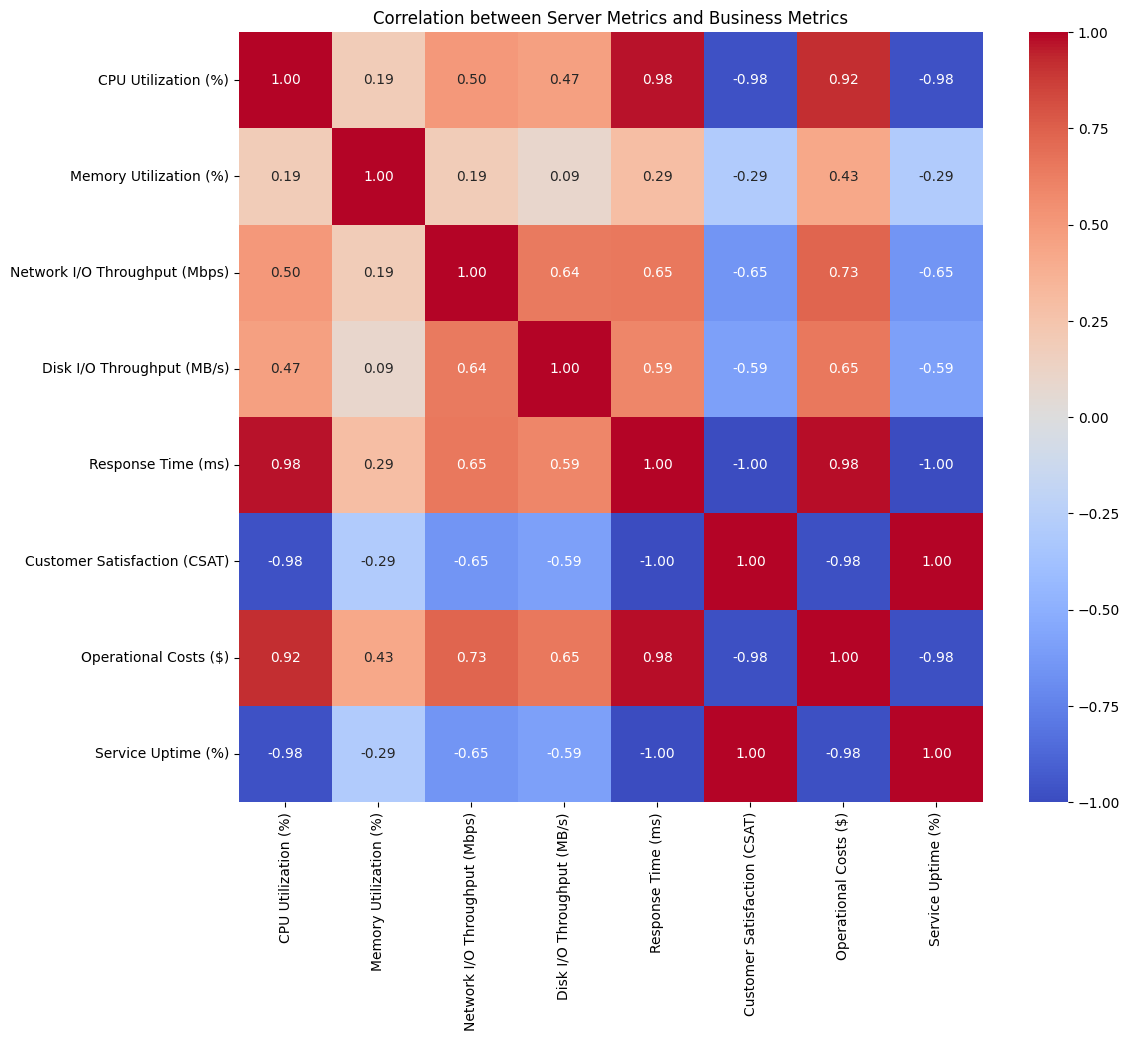

In [463]:
# Step 7: Business Analysis

# Ensure 'Timestamp' column is present and convert to datetime
if "Timestamp" not in server_metrics.columns:
    raise KeyError("The 'Timestamp' column is missing in the server_metrics DataFrame.")
if "Timestamp" not in business_metrics.columns:
    raise KeyError(
        "The 'Timestamp' column is missing in the business_metrics DataFrame."
    )

server_metrics["Timestamp"] = pd.to_datetime(server_metrics["Timestamp"])
business_metrics["Timestamp"] = pd.to_datetime(business_metrics["Timestamp"])

# Aligning data based on Timestamp
server_metrics.set_index("Timestamp", inplace=True)
business_metrics.set_index("Timestamp", inplace=True)

# Ensure both dataframes are aligned
aligned_data = server_metrics.join(
    business_metrics, how="inner", lsuffix="_server", rsuffix="_business"
)

# Print columns to check names after joining
print("Aligned Data Columns:")
print(aligned_data.columns)

# Check for and drop missing values, if any
aligned_data.dropna(inplace=True)

# Split back into server and business metrics
server_cols = [
    "CPU Utilization (%)",
    "Memory Utilization (%)",
    "Network I/O Throughput (Mbps)",
    "Disk I/O Throughput (MB/s)",
]
business_cols = [
    "Response Time (ms)",
    "Customer Satisfaction (CSAT)",
    "Operational Costs ($)",
    "Service Uptime (%)",
]

numeric_server_metrics = aligned_data[server_cols]
numeric_business_metrics = aligned_data[business_cols]

# Rename columns for easier access
numeric_server_metrics.columns = [
    "CPU Utilization (%)",
    "Memory Utilization (%)",
    "Network I/O Throughput (Mbps)",
    "Disk I/O Throughput (MB/s)",
]
numeric_business_metrics.columns = [
    "Response Time (ms)",
    "Customer Satisfaction (CSAT)",
    "Operational Costs ($)",
    "Service Uptime (%)",
]

# Compute the correlation matrix between server metrics and business metrics
correlation_matrix = numeric_server_metrics.join(numeric_business_metrics).corr()
print("Correlation with Business Metrics:")
print(correlation_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of correlations between server metrics and business metrics
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Server Metrics and Business Metrics")
plt.show()

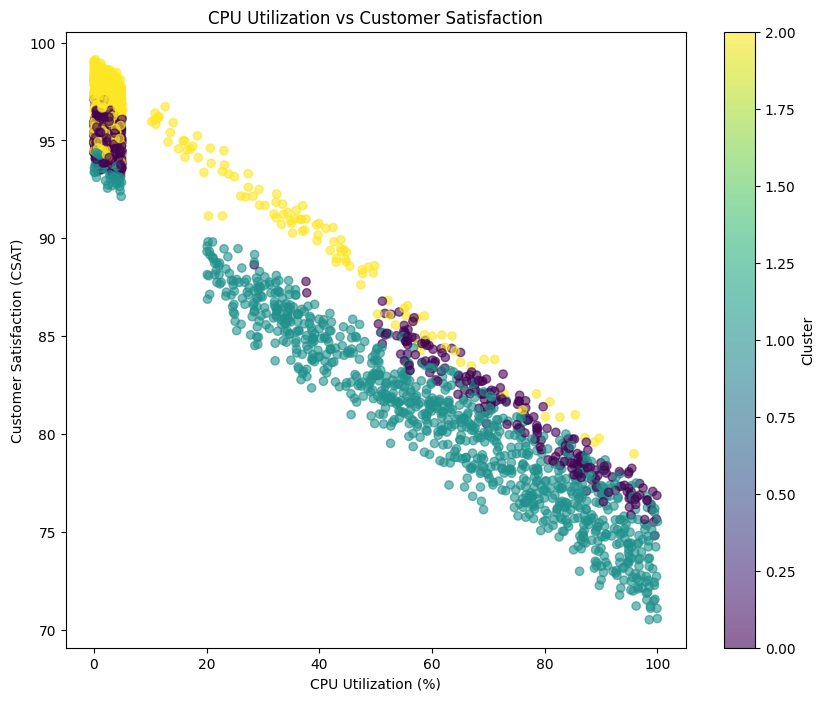

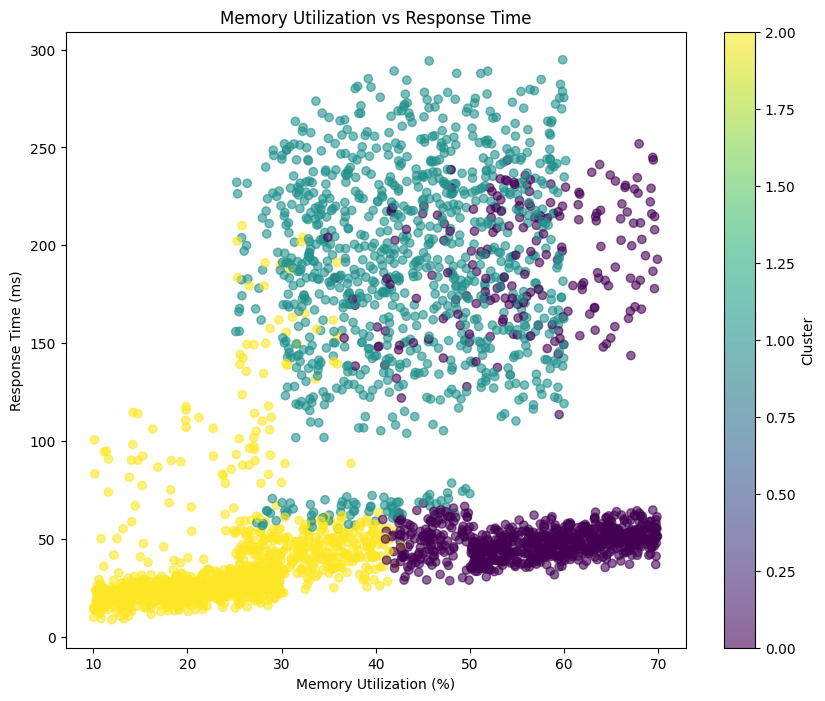

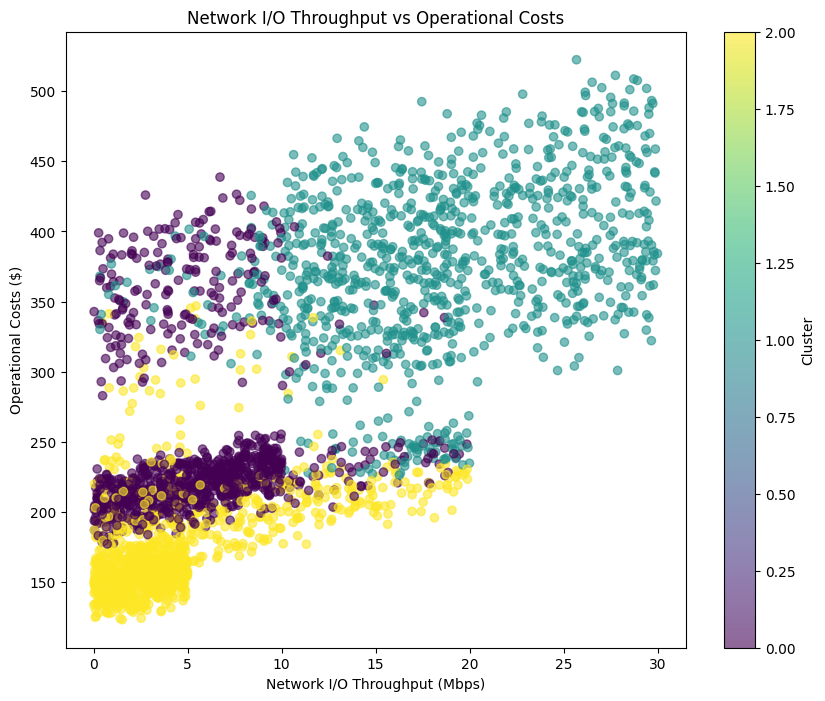

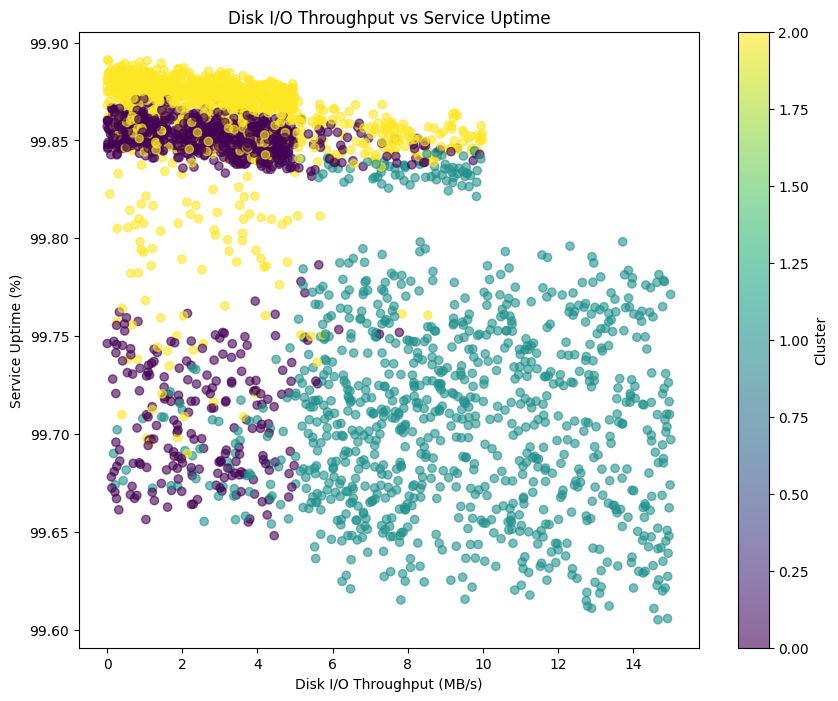


Insights:
CPU Utilization (%) and Customer Satisfaction (CSAT): -0.98
Memory Utilization (%) and Response Time (ms): 0.29
Network I/O Throughput (Mbps) and Operational Costs ($): 0.73
Disk I/O Throughput (MB/s) and Service Uptime (%): -0.59

Interpretation of Insights:
A strong negative correlation of -0.98 between CPU Utilization (%) and Customer Satisfaction (CSAT) suggests that as CPU Utilization (%) increases, Customer Satisfaction (CSAT) decreases.
A weak correlation of 0.29 between Memory Utilization (%) and Response Time (ms) suggests that changes in Memory Utilization (%) have little impact on Response Time (ms).
A strong positive correlation of 0.73 between Network I/O Throughput (Mbps) and Operational Costs ($) suggests that as Network I/O Throughput (Mbps) increases, Operational Costs ($) also increases.
A strong negative correlation of -0.59 between Disk I/O Throughput (MB/s) and Service Uptime (%) suggests that as Disk I/O Throughput (MB/s) increases, Service Uptime (%) d

/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1811198254.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1811198254.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1811198254.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1811198254.py:148: UserWarning: set_ticklabels() should only be used with a fi

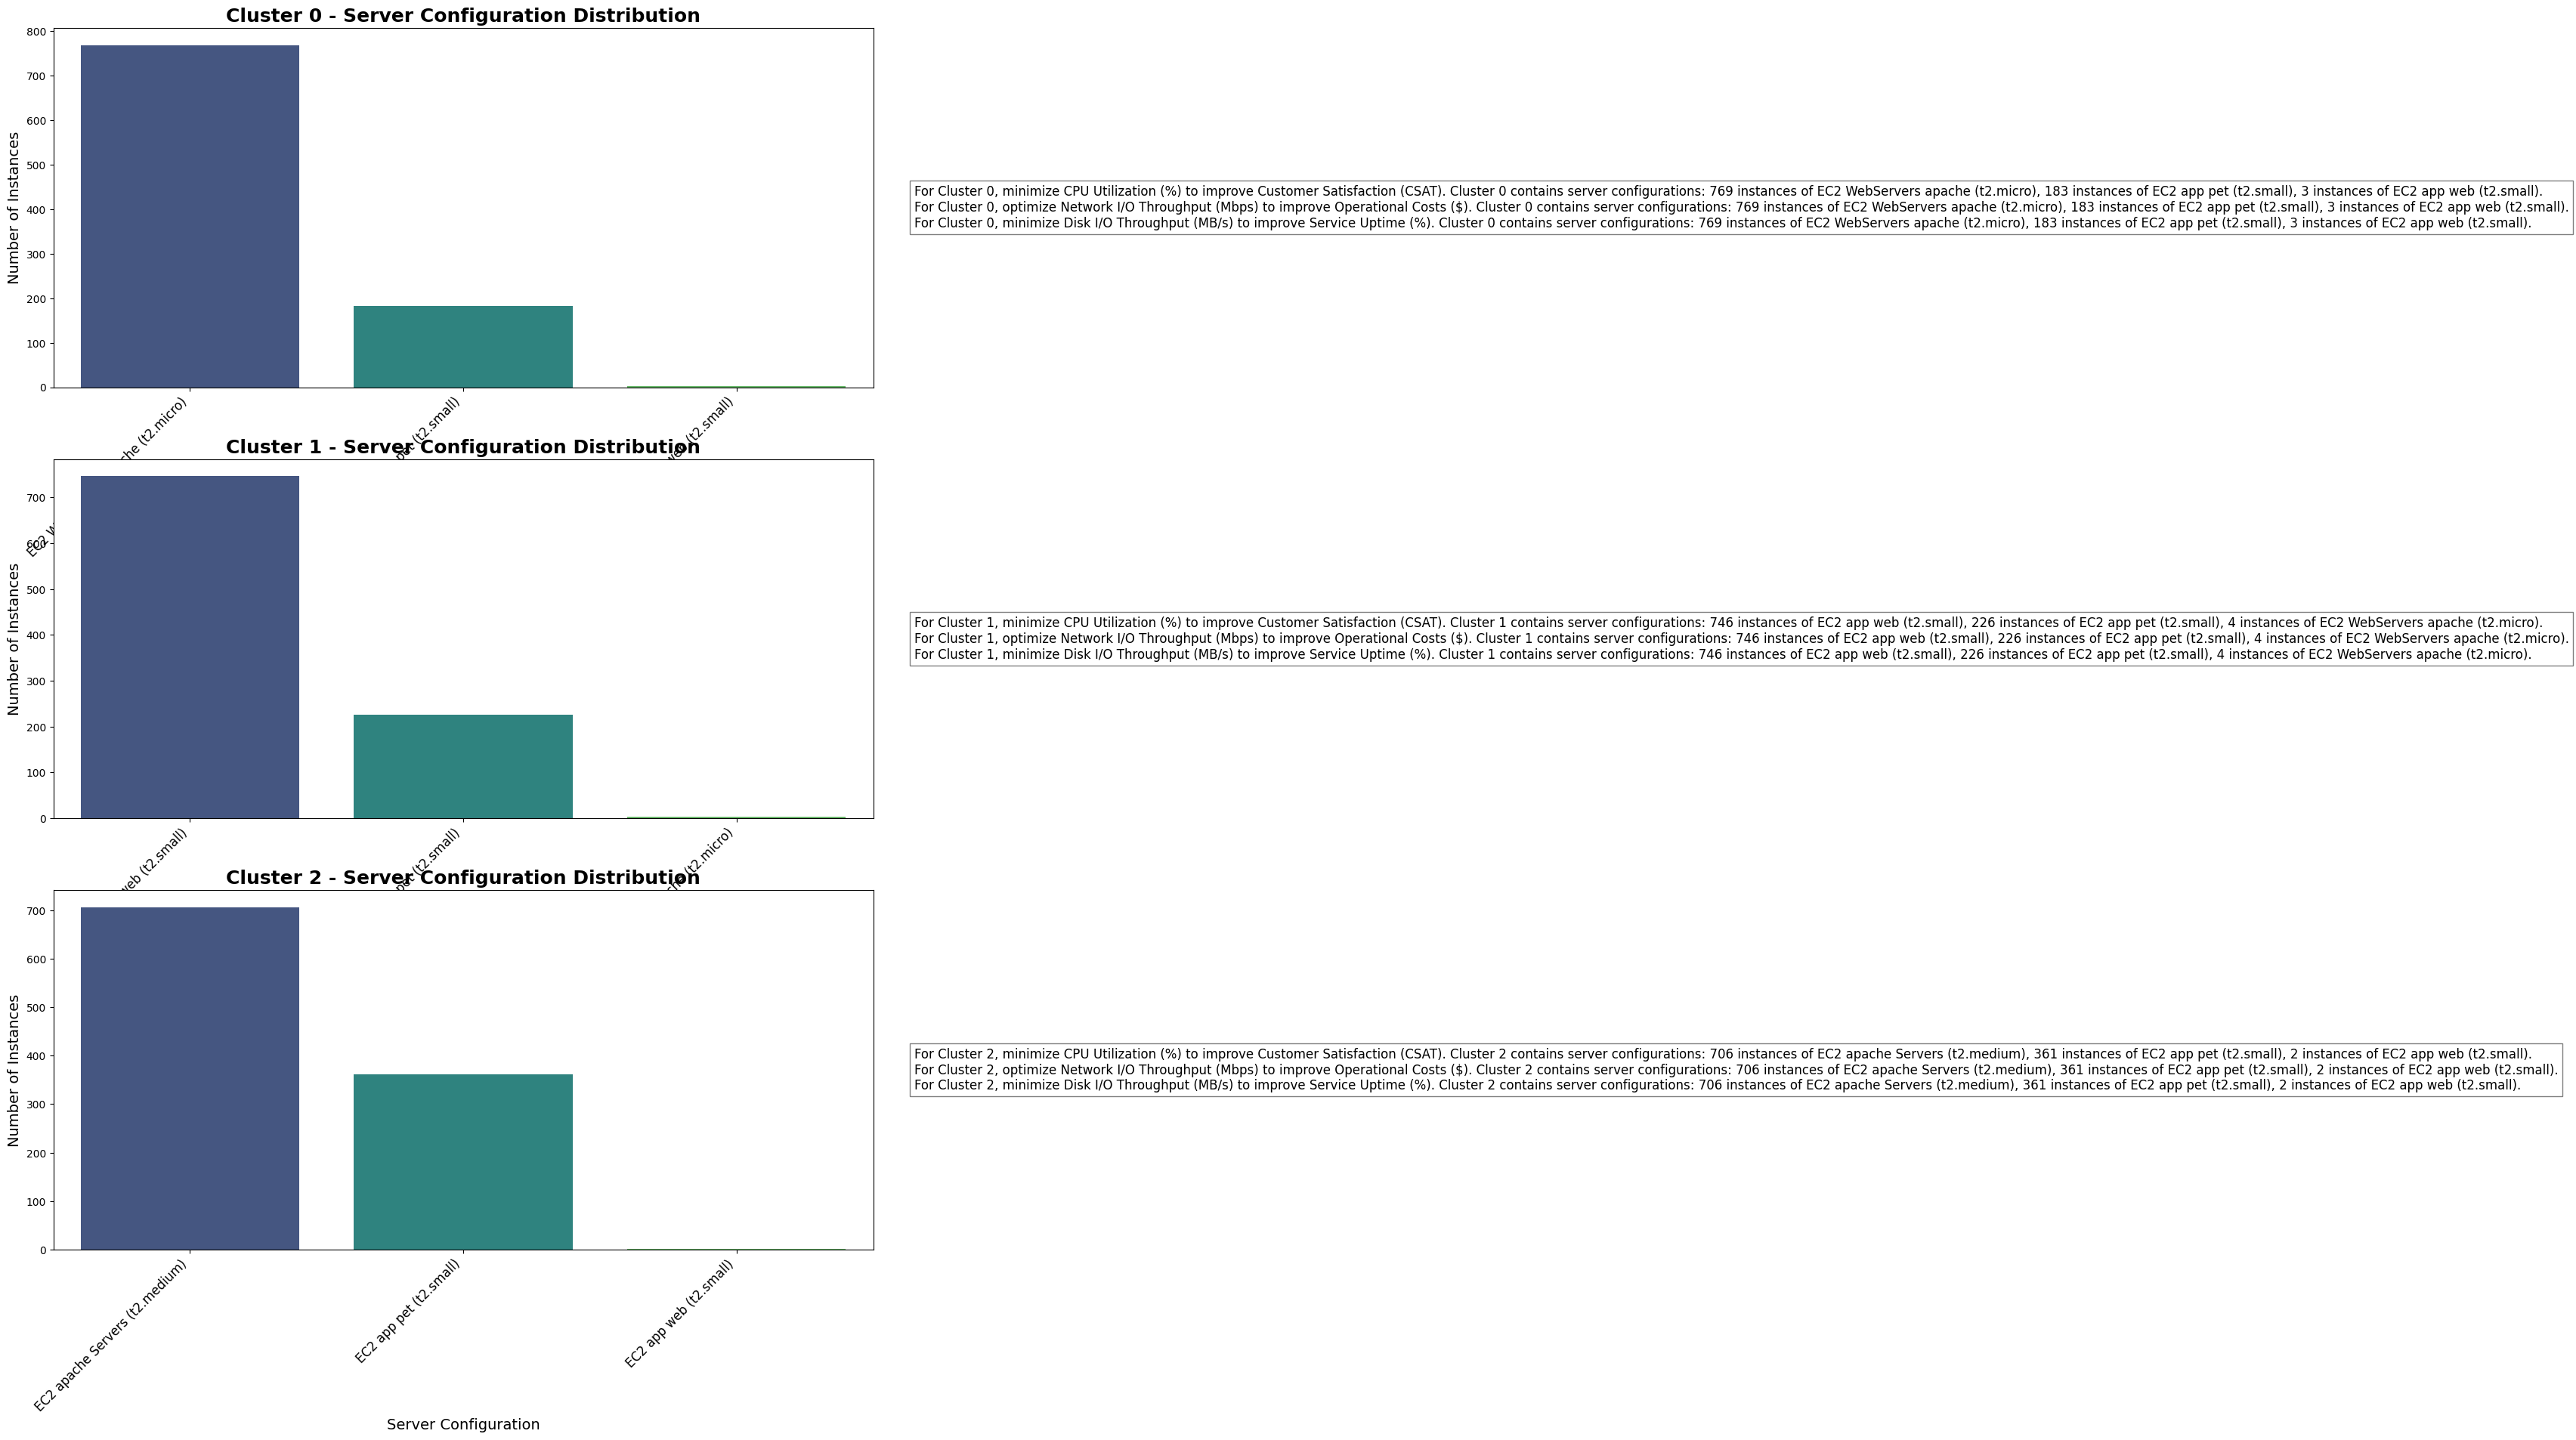

In [464]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 8: Optimization Recommendations & Business Insights

# Scatter plot function
def plot_scatter(x, y, clusters, xlabel, ylabel, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, c=clusters, cmap="viridis", alpha=0.6)
    plt.colorbar(label="Cluster")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# Assuming aligned_data and correlation_matrix are defined appropriately

# Define scatter plots with feature pairs and titles
scatter_plots = [
    (
        "CPU Utilization (%)",
        "Customer Satisfaction (CSAT)",
        "CPU Utilization vs Customer Satisfaction",
    ),
    (
        "Memory Utilization (%)",
        "Response Time (ms)",
        "Memory Utilization vs Response Time",
    ),
    (
        "Network I/O Throughput (Mbps)",
        "Operational Costs ($)",
        "Network I/O Throughput vs Operational Costs",
    ),
    (
        "Disk I/O Throughput (MB/s)",
        "Service Uptime (%)",
        "Disk I/O Throughput vs Service Uptime",
    ),
]

# Generate Scatter Plots
for x_feature, y_feature, plot_title in scatter_plots:
    plot_scatter(
        aligned_data[x_feature],
        aligned_data[y_feature],
        aligned_data["Cluster"],
        x_feature,
        y_feature,
        plot_title,
    )

# Generate Insights dynamically
insights = {}
for x_feature, y_feature, _ in scatter_plots:
    correlation = correlation_matrix.loc[x_feature, y_feature]
    insights[f"{x_feature} and {y_feature}"] = correlation

print("\nInsights:")
for k, v in insights.items():
    print(f"{k}: {v:.2f}")


#  Automated Insights Interpretation
def interpret_insights(insights):
    for key, correlation in insights.items():
        feature1, feature2 = key.split(" and ")
        if correlation > 0.5:
            print(
                f"A strong positive correlation of {correlation:.2f} between {feature1} and {feature2} suggests that as {feature1} increases, {feature2} also increases."
            )
        elif correlation < -0.5:
            print(
                f"A strong negative correlation of {correlation:.2f} between {feature1} and {feature2} suggests that as {feature1} increases, {feature2} decreases."
            )
        else:
            print(
                f"A weak correlation of {correlation:.2f} between {feature1} and {feature2} suggests that changes in {feature1} have little impact on {feature2}."
            )


print("\nInterpretation of Insights:")
interpret_insights(insights)

# Function to generate optimization recommendations based on correlations and cluster info
def optimization_recommendations(correlations, cluster_info):
    recommendations = []
    for key, correlation in correlations.items():
        feature1, feature2 = key.split(" and ")
        if correlation > 0.5:
            action = "optimize"
        elif correlation < -0.5:
            action = "minimize"
        else:
            continue

        for cluster, info in cluster_info.items():
            recommendations.append(
                f"For Cluster {cluster}, {action} {feature1} to improve {feature2}. "
                f"Cluster {cluster} contains server configurations: {', '.join([f'{count} instances of {config}' for config, count in info['server_types'].items()])}."
            )

    return recommendations


print("\nOptimization Recommendations:")
recommendations = optimization_recommendations(insights, cluster_info)
for recommendation in recommendations:
    print(f"- {recommendation}")


# Function to plot server configuration distribution for each cluster
# Function to plot server configuration distribution for each cluster
def plot_cluster_distributions(cluster_info, recommendations):
    num_clusters = len(cluster_info)

    fig, axes = plt.subplots(
        nrows=num_clusters, ncols=1, figsize=(14, 7 * num_clusters)
    )
    if num_clusters == 1:
        axes = [axes]  # Ensure axes is always a list for consistency

    for idx, (cluster, ax) in enumerate(zip(cluster_info.keys(), axes)):
        cluster_data = cluster_info[cluster]
        server_configs = cluster_data["server_types"]
        server_configs_sorted = dict(
            sorted(server_configs.items(), key=lambda item: item[1], reverse=True)
        )

        # Use distinct colors for each cluster
        palette = sns.color_palette("viridis", len(server_configs_sorted))

        sns.barplot(
            x=list(server_configs_sorted.keys()),
            y=list(server_configs_sorted.values()),
            ax=ax,
            palette=palette,
        )

        ax.set_title(
            f"Cluster {cluster} - Server Configuration Distribution",
            fontsize=18,
            weight="bold",
        )
        ax.set_xlabel("Server Configuration", fontsize=14)
        ax.set_ylabel("Number of Instances", fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

        # Add recommendations to the plot
        cluster_recommendations = [
            rec for rec in recommendations if f"Cluster {cluster}" in rec
        ]
        recommendation_text = "\n".join(cluster_recommendations)
        ax.text(
            1.05,
            0.5,
            recommendation_text,
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="center",
            bbox=dict(facecolor="white", alpha=0.5),
        )

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to fit text boxes
    plt.show()

plot_cluster_distributions(cluster_info, recommendations)

Estimated Cost Reduction per Cluster (per instance per month):
Cluster 0: $297.66
Cluster 1: $963.16
Cluster 2: $231.22


/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/163497142.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=server_types, y=server_savings, palette="viridis", ax=axes[0])
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/163497142.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/163497142.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=workloads, y=workload_savings_values, palette="viridis", ax=axes[1])
/var/folders/d0/q7jj6ds52cg04vr9dbw4v5780000gn/T/ipykernel_63373/1634

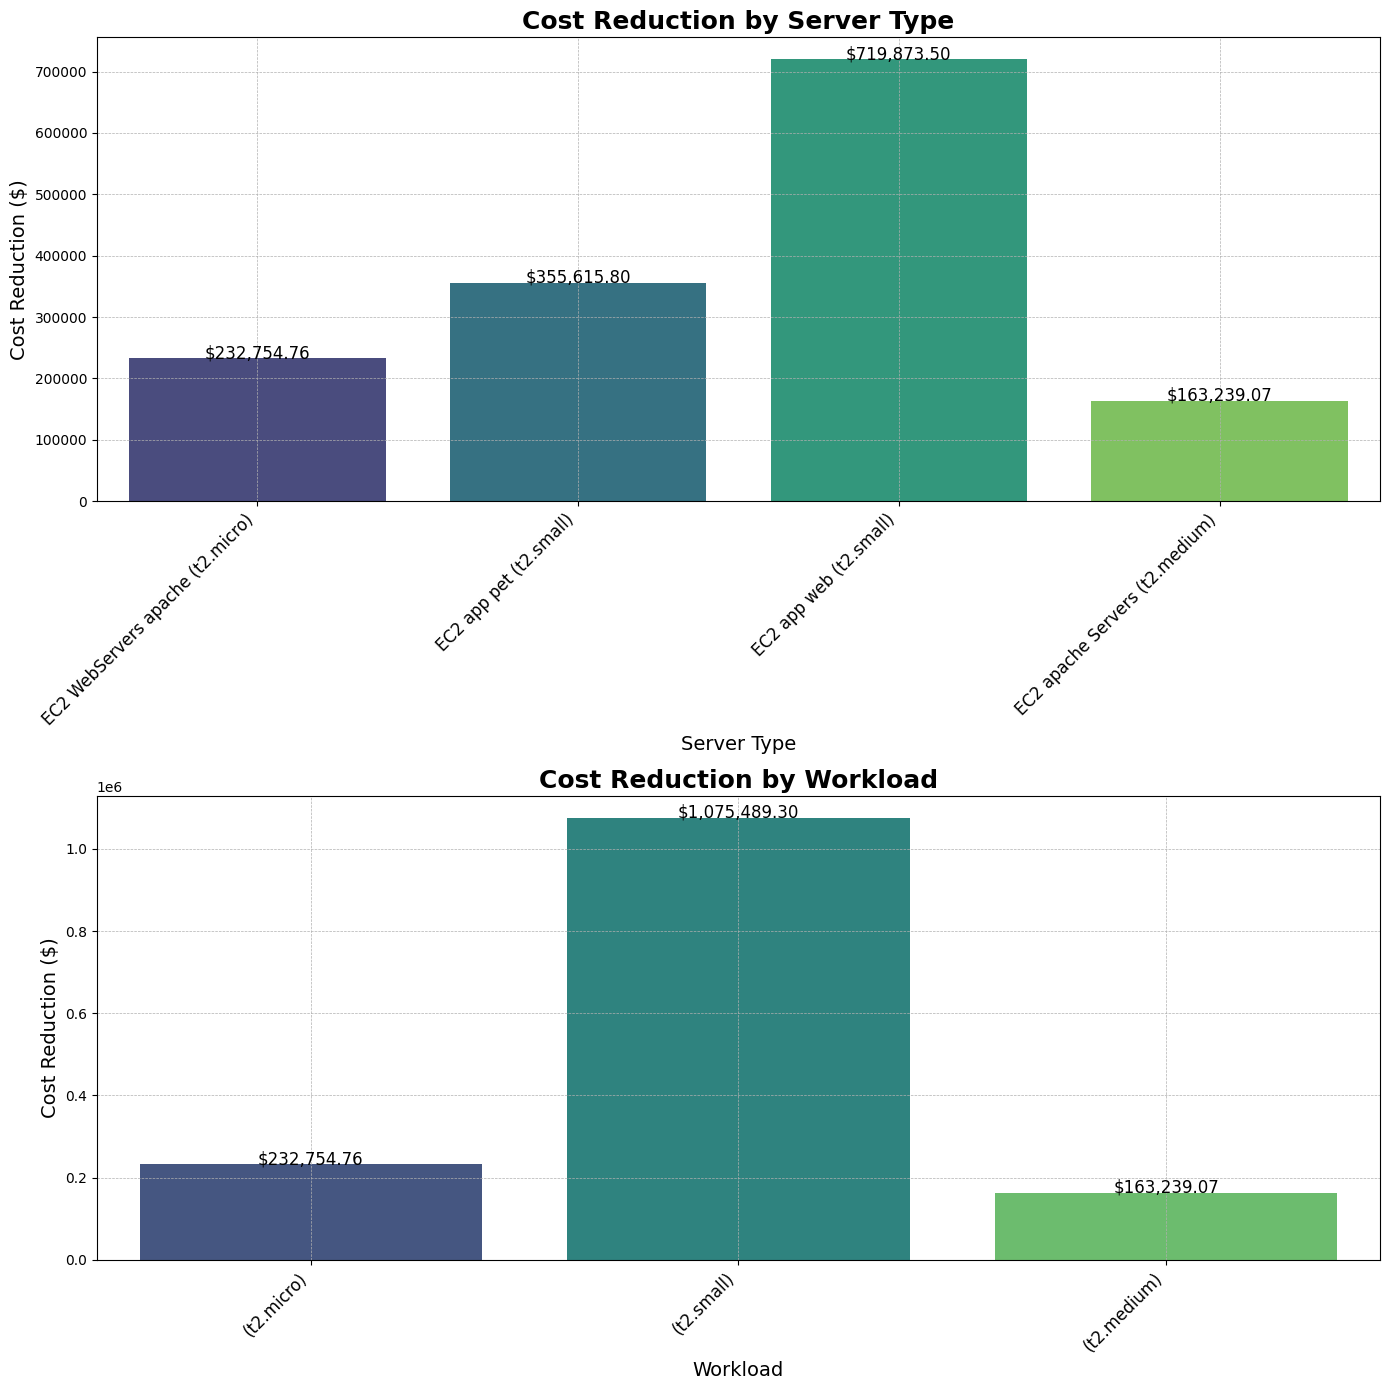

In [465]:
import numpy as np


# Function to estimate cost savings based on recommendations
def estimate_cost_reduction(cluster_info, recommendations, cost_factors):
    cost_savings = {}
    server_type_savings = {}
    workload_savings = {}

    for cluster, info in cluster_info.items():
        cluster_recommendations = [
            rec for rec in recommendations if f"Cluster {cluster}" in rec
        ]
        savings = 0

        for rec in cluster_recommendations:
            if "minimize CPU Utilization" in rec:
                savings += info["cpu_utilization_mean"] * cost_factors["CPU"]
            if "optimize Network I/O Throughput" in rec:
                savings += info["network_io_mean"] * cost_factors["Network"]
            if "minimize Disk I/O Throughput" in rec:
                savings += info["disk_io_mean"] * cost_factors["Disk"]

        cost_savings[cluster] = savings

        for server_type, count in info["server_types"].items():
            server_savings = savings * count
            if server_type not in server_type_savings:
                server_type_savings[server_type] = 0
            server_type_savings[server_type] += server_savings

            workload = server_type.split(" ")[-1]  # Extract workload from server type
            if workload not in workload_savings:
                workload_savings[workload] = 0
            workload_savings[workload] += server_savings

    return cost_savings, server_type_savings, workload_savings


# Real AWS cost factors
cost_factors = {
    "CPU": 0.05,  # $0.05 per 1% CPU utilization reduction per instance per month
    "Network": 0.072 * 24 * 30,  # $0.072 per Mbps per hour, converted to monthly cost
    "Disk": 0.10,  # $0.10 per GB per month (assuming general-purpose SSD)
}

cost_reduction, server_type_savings, workload_savings = estimate_cost_reduction(
    cluster_info, recommendations, cost_factors
)

# Print cost reduction estimates
print("Estimated Cost Reduction per Cluster (per instance per month):")
for cluster, saving in cost_reduction.items():
    print(f"Cluster {cluster}: ${saving:.2f}")


# Function to plot cost reduction by server type and workload
def plot_cost_reduction_comparison(server_type_savings, workload_savings):
    server_types = list(server_type_savings.keys())
    server_savings = list(server_type_savings.values())

    workloads = list(workload_savings.keys())
    workload_savings_values = list(workload_savings.values())

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

    sns.barplot(x=server_types, y=server_savings, palette="viridis", ax=axes[0])
    axes[0].set_title("Cost Reduction by Server Type", fontsize=18, weight="bold")
    axes[0].set_xlabel("Server Type", fontsize=14)
    axes[0].set_ylabel("Cost Reduction ($)", fontsize=14)
    axes[0].set_xticklabels(
        axes[0].get_xticklabels(), rotation=45, ha="right", fontsize=12
    )
    for i in range(len(server_savings)):
        axes[0].text(
            i,
            server_savings[i] + 100,
            f"${server_savings[i]:,.2f}",
            ha="center",
            fontsize=12,
        )

    sns.barplot(x=workloads, y=workload_savings_values, palette="viridis", ax=axes[1])
    axes[1].set_title("Cost Reduction by Workload", fontsize=18, weight="bold")
    axes[1].set_xlabel("Workload", fontsize=14)
    axes[1].set_ylabel("Cost Reduction ($)", fontsize=14)
    axes[1].set_xticklabels(
        axes[1].get_xticklabels(), rotation=45, ha="right", fontsize=12
    )
    for i in range(len(workload_savings_values)):
        axes[1].text(
            i,
            workload_savings_values[i] + 100,
            f"${workload_savings_values[i]:,.2f}",
            ha="center",
            fontsize=12,
        )

    for ax in axes:
        ax.grid(True, linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


# Plot cost reduction comparison
plot_cost_reduction_comparison(server_type_savings, workload_savings)